In [1]:
# trying different ways to initialise the weights to see
# if I can fit high frequency functions

In [66]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from cycler import cycler
from itertools import cycle

mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("ggplot")
mpl.rcParams.update({"font.size": 16})

In [185]:
import tensorflow_addons as tfa

In [109]:
import datetime

# main

In [3]:
def plot_prediction_and_error(x, y, model=None, yhat=None):
    if model:
        yhat = model.predict(x)

    yRes = y - yhat
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    axes[0].plot(x, y)
    axes[0].plot(x, yhat)
    axes[1].plot(x, yRes)
    plt.show()
    plt.close()

In [4]:
def gen_test_data():
#     x = np.linspace(-np.pi/2., np.pi/2., 100)
    x = np.linspace(-1, 1, 100)[:,np.newaxis]
    y = np.cos(20*x) + np.sin(10*x)
#     y = np.cos(50*x) + np.sin(5*x)

    noise = np.random.normal(0, 0.1, size=x.shape)

    return x, y + noise

x, y = gen_test_data()


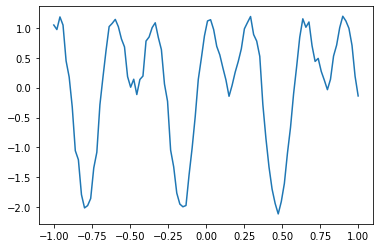

In [5]:
plt.figure()
plt.plot(x, y)
plt.show()
plt.close()

In [226]:
def get_base_model(x, y, verbose=True, batch_size=100, epochs=1000, act='tanh'):

    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(1,)),
        tf.keras.layers.Dense(200, activation=act),
#         tfa.layers.WeightNormalization(tf.keras.layers.Dense(200, activation=act)),
        tf.keras.layers.Dense(200, activation=act),
        tf.keras.layers.Dense(1)
    ])
    
#     optimizer = tf.keras.optimizers.Adam(0.001)
    optimizer = tfa.optimizers.LazyAdam(0.001)
    model.compile(loss='mse', optimizer=optimizer)
    
    history = model.fit(x, y, batch_size=batch_size, epochs=epochs, verbose=verbose)
    
    return history, model

In [227]:
def get_later_model(x, y, verbose=True, batch_size=100, epochs=1000, act='relu', tensorboard=False):

    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(1,)),
        tf.keras.layers.Dense(1000, activation=act),
        tf.keras.layers.Dense(1000, activation=act),
        tf.keras.layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.Adam(0.001)
#     optimizer = tfa.optimizers.LazyAdam(0.001)
    model.compile(loss='mse', optimizer=optimizer)

    callbacks=[]
    
    if tensorboard:
        log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
        callbacks.append(tensorboard_callback)
    
    history = model.fit(x, y, batch_size=batch_size, epochs=epochs, verbose=verbose, callbacks=callbacks)
    
    return history, model

## using 2-step method

In [228]:
%%time
history, model = get_base_model(x, y, verbose=False, act='tanh', epochs=10000)

CPU times: user 20 s, sys: 3.04 s, total: 23 s
Wall time: 10.4 s


In [229]:
model.summary()

Model: "sequential_80"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_241 (Dense)            (None, 200)               400       
_________________________________________________________________
dense_242 (Dense)            (None, 200)               40200     
_________________________________________________________________
dense_243 (Dense)            (None, 1)                 201       
Total params: 40,801
Trainable params: 40,801
Non-trainable params: 0
_________________________________________________________________


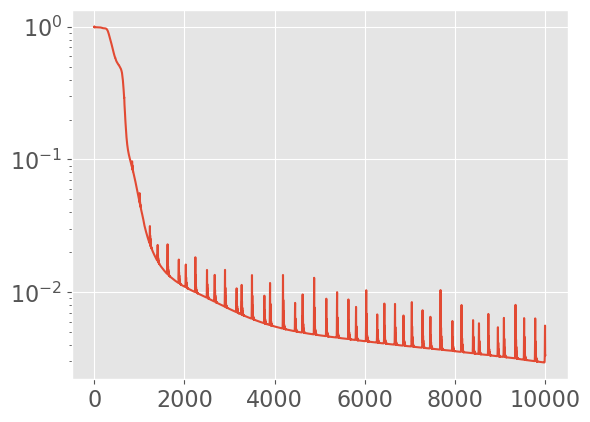

In [230]:
plt.figure()
plt.plot(history.history['loss'])
plt.yscale('log')

In [231]:
yhat = model.predict(x)

In [232]:
yRes = y-yhat

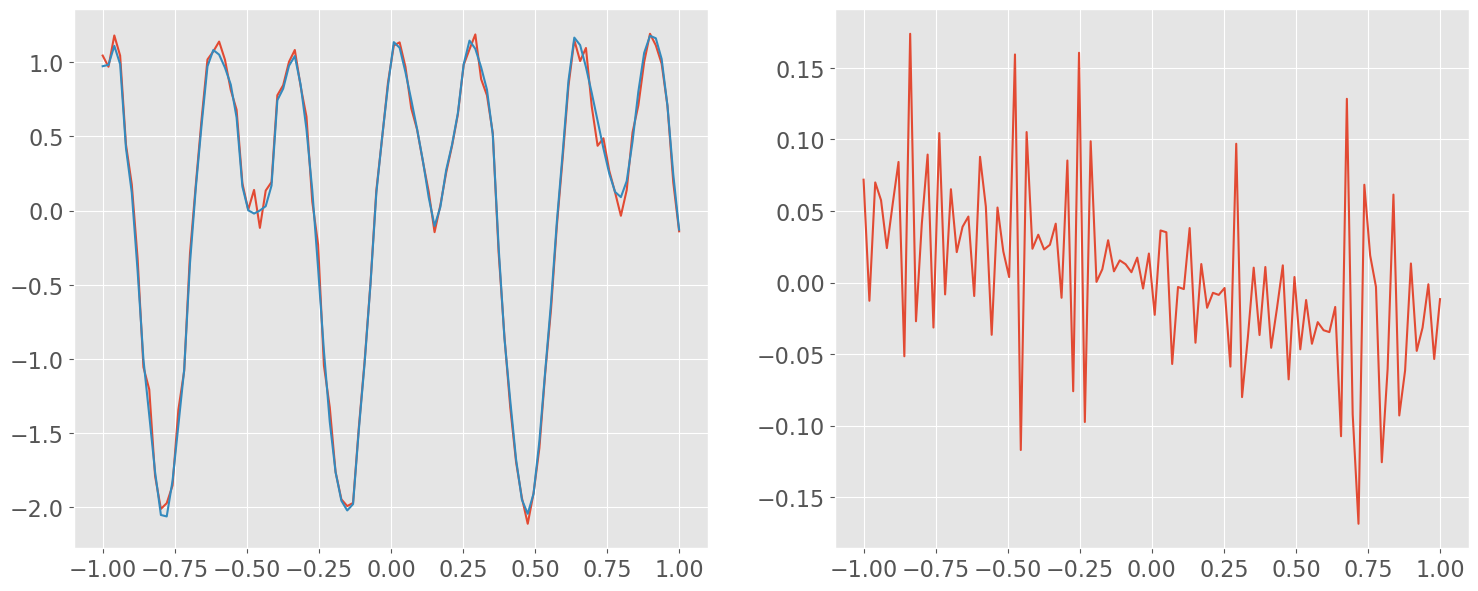

In [233]:
plot_prediction_and_error(x, y, model)

In [234]:
%%time
history2, model2 = get_later_model(x, yRes, False, epochs=30000, act='relu')
# history2, model2 = get_later_model(x, yRes, False, epochs=30000, act='tanh')

CPU times: user 10min 41s, sys: 20.6 s, total: 11min 2s
Wall time: 2min 6s


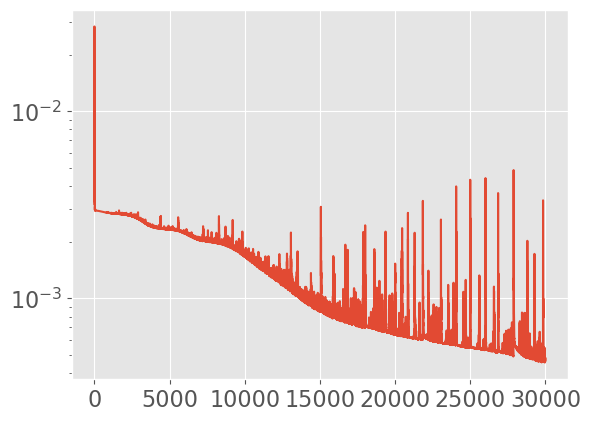

In [235]:
h2 = history2.history['loss']
plt.figure()
plt.plot(range(len(h2)), h2)
plt.yscale('log')

In [236]:
yhat2 = model2.predict(x)

In [237]:
yRes2 = yRes-yhat2

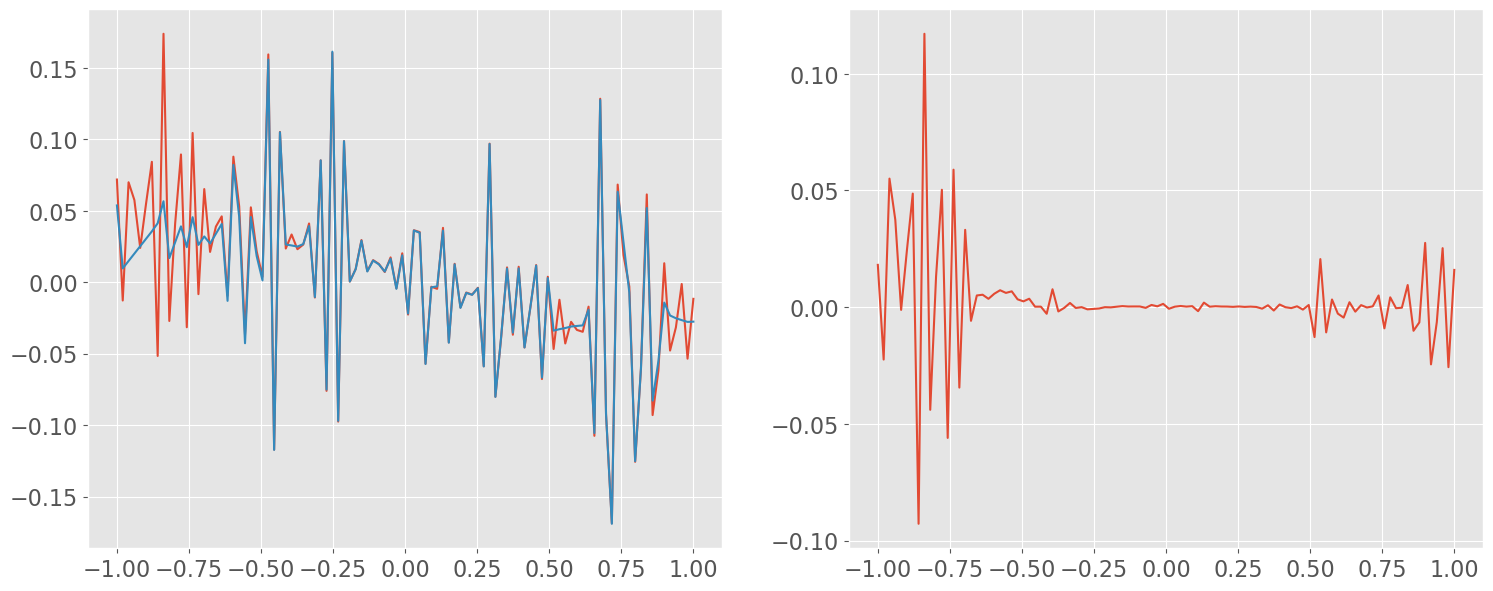

In [238]:
plot_prediction_and_error(x, yRes, model2)

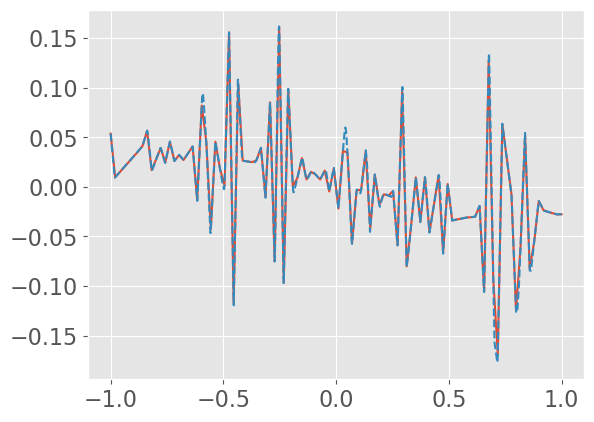

In [239]:
x_prime = np.linspace(-1, 1, 10000)[:, np.newaxis]
y_prime = model2.predict(x_prime)
plt.figure()
plt.plot(x, model2.predict(x))
plt.plot(x_prime, y_prime, ls='--')

In [240]:
yhat_multistep = model.predict(x) + model2.predict(x)

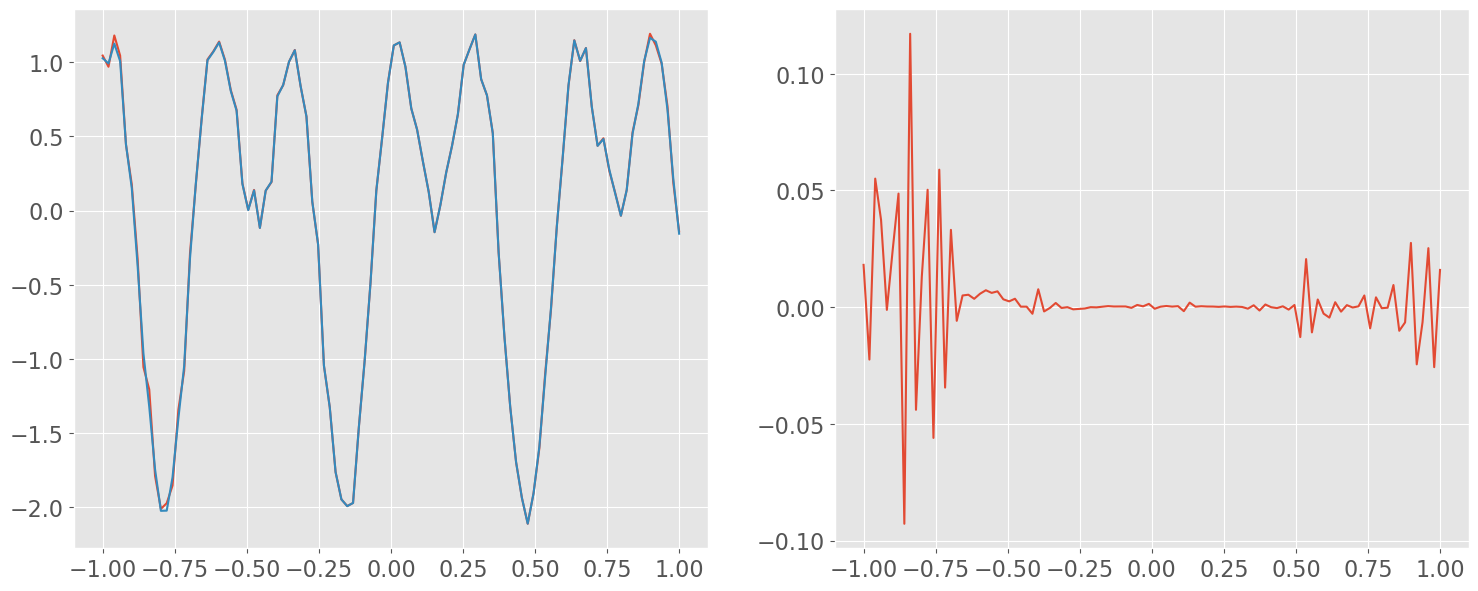

In [241]:
plot_prediction_and_error(x, y, model=None, yhat=yhat_multistep)

In [242]:
yhat_multistep_loss = tf.keras.losses.mean_squared_error(y, yhat_multistep)

(1e-12, 1)

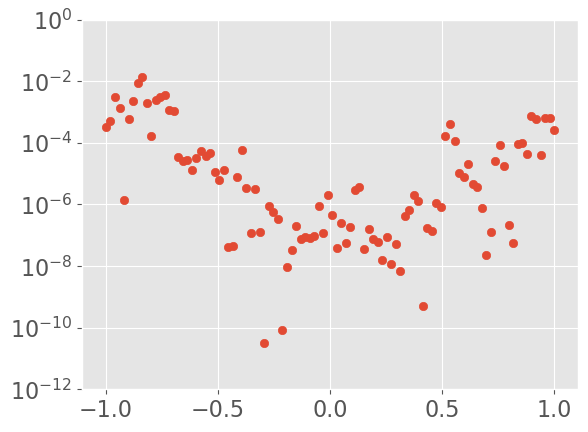

In [243]:
plt.figure()
plt.scatter(x, yhat_multistep_loss)
plt.yscale('log')
plt.ylim(1e-12, 1)

In [244]:
model2.summary()

Model: "sequential_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_244 (Dense)            (None, 1000)              2000      
_________________________________________________________________
dense_245 (Dense)            (None, 1000)              1001000   
_________________________________________________________________
dense_246 (Dense)            (None, 1)                 1001      
Total params: 1,004,001
Trainable params: 1,004,001
Non-trainable params: 0
_________________________________________________________________


In [245]:
model2.layers[0].get_weights()[0].shape

(1, 1000)

In [246]:
model2.layers[0].get_weights()[1].shape

(1000,)

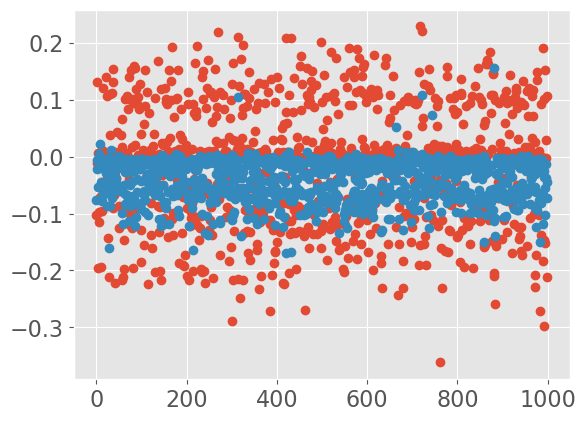

In [247]:
plt.figure()
plt.plot(model2.layers[0].get_weights()[0][0], 'o')
plt.plot(model2.layers[0].get_weights()[1], 'o')

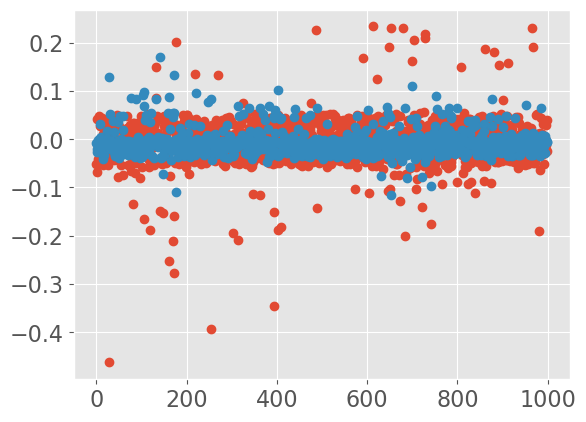

In [248]:
plt.figure()
plt.plot(model2.layers[1].get_weights()[0][0], 'o')
plt.plot(model2.layers[1].get_weights()[1], 'o')

# trying different kernal initializers

In [ ]:
# options: https://www.tensorflow.org/api_docs/python/tf/keras/initializers

# example
# initializer = tf.keras.initializers.GlorotNormal()
# layer = tf.keras.layers.Dense(3, kernel_initializer=initializer)

In [250]:
initializers = {
#     'GlorotNormal':tf.keras.initializers.GlorotNormal(),
#     'GlorotUniform':tf.keras.initializers.GlorotUniform(),
#     'HeNormal':tf.keras.initializers.HeNormal(),
#     'HeUniform':tf.keras.initializers.HeUniform(),
#     'Identity':tf.keras.initializers.Identity(gain=1.0),
#     'LecunNormal':tf.keras.initializers.LecunNormal(),
#     'LecunUniform':tf.keras.initializers.LecunUniform(),
#     'Ones':tf.keras.initializers.Ones(),
#     'Orthogonal':tf.keras.initializers.Orthogonal(gain=1.0),
#     'RandomNormal':tf.keras.initializers.RandomNormal(mean=0., stddev=0.05),
#     'RandomUniform':tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
#     'TruncatedNormal':tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05),
#     'VarianceScaling':tf.keras.initializers.VarianceScaling(scale=1.0, mode='fan_in', distribution='truncated_normal'),
#     'Zeros':tf.keras.initializers.Zeros(),
#     'RandomNormal':tf.keras.initializers.RandomNormal(mean=0., stddev=10.05),
#     'RandomUniform':tf.keras.initializers.RandomUniform(minval=-0.005, maxval=0.005),
    'RandomNormal_2':tf.keras.initializers.RandomNormal(mean=0., stddev=0.1),
#     'RandomUniform_2':tf.keras.initializers.RandomUniform(minval=-0.0005, maxval=0.0005),
}

In [288]:
def fit_vary_kernal(x, y, initializer, verbose=True, batch_size=100, epochs=1000, act='relu'):

    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(1,)),
        tf.keras.layers.Dense(1000, activation=act, kernel_initializer=initializer),
        tf.keras.layers.Dense(1000, activation=act, kernel_initializer=initializer),
        tf.keras.layers.Dense(1)
    ])
    
#     optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
    
    optimizer = tf.keras.optimizers.Adam(0.001)
#     optimizer = tfa.optimizers.RectifiedAdam(0.001)

#     step = tf.Variable(0, trainable=False)
#     schedule = tf.optimizers.schedules.PiecewiseConstantDecay(
#         [10000, 15000], [1e-0, 1e-1, 1e-2])
#     # lr and wd can be a function or a tensor
#     lr = 1e-3 * schedule(step)
#     wd = lambda: 1e-4 * schedule(step)
#     optimizer = tfa.optimizers.AdamW(learning_rate=lr, weight_decay=wd)

    model.compile(loss='mse', optimizer=optimizer)
    
    history = model.fit(x, y, batch_size=batch_size, epochs=epochs, verbose=verbose)
    
    return history, model

In [293]:
# epochs = 1000
# epochs = 10000
# epochs = 30000
epochs = 50000
models = {}
historys = {}
for k,v in initializers.items():
    print(k)
    start_time = datetime.datetime.now()
    historys[k], models[k] = fit_vary_kernal(x=x, y=yRes, initializer=v, verbose=False, epochs=epochs, act='relu')
    end_time = datetime.datetime.now()
    duration = end_time - start_time
    print(f"duration = {duration}")
print("finished")

RandomNormal_2
duration = 0:03:39.038317
finished


In [319]:
historys[k] = models[k].fit(x, yRes, verbose=False, epochs=10000, batch_size=100)

In [320]:
last_losses = {}
for k in historys.keys():
    last_losses[k]=historys[k].history['loss'][-1]
    print(f"{k}: \t {np.around(last_losses[k], 5)}")

RandomNormal_2: 	 2e-05


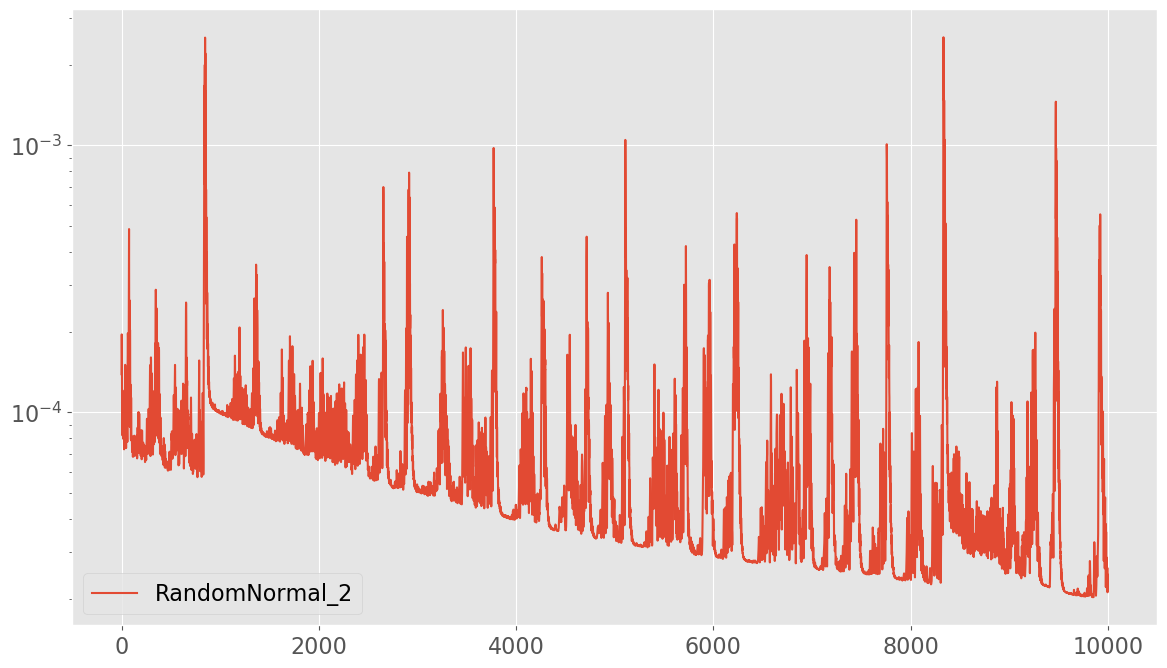

In [321]:
plt.figure(figsize=(14, 8))
for k in historys.keys():
    plt.plot(historys[k].history['loss'], label=k)
plt.yscale('log')
# plt.xscale('log')
# plt.ylim(1e-4, 1e0)
plt.legend()

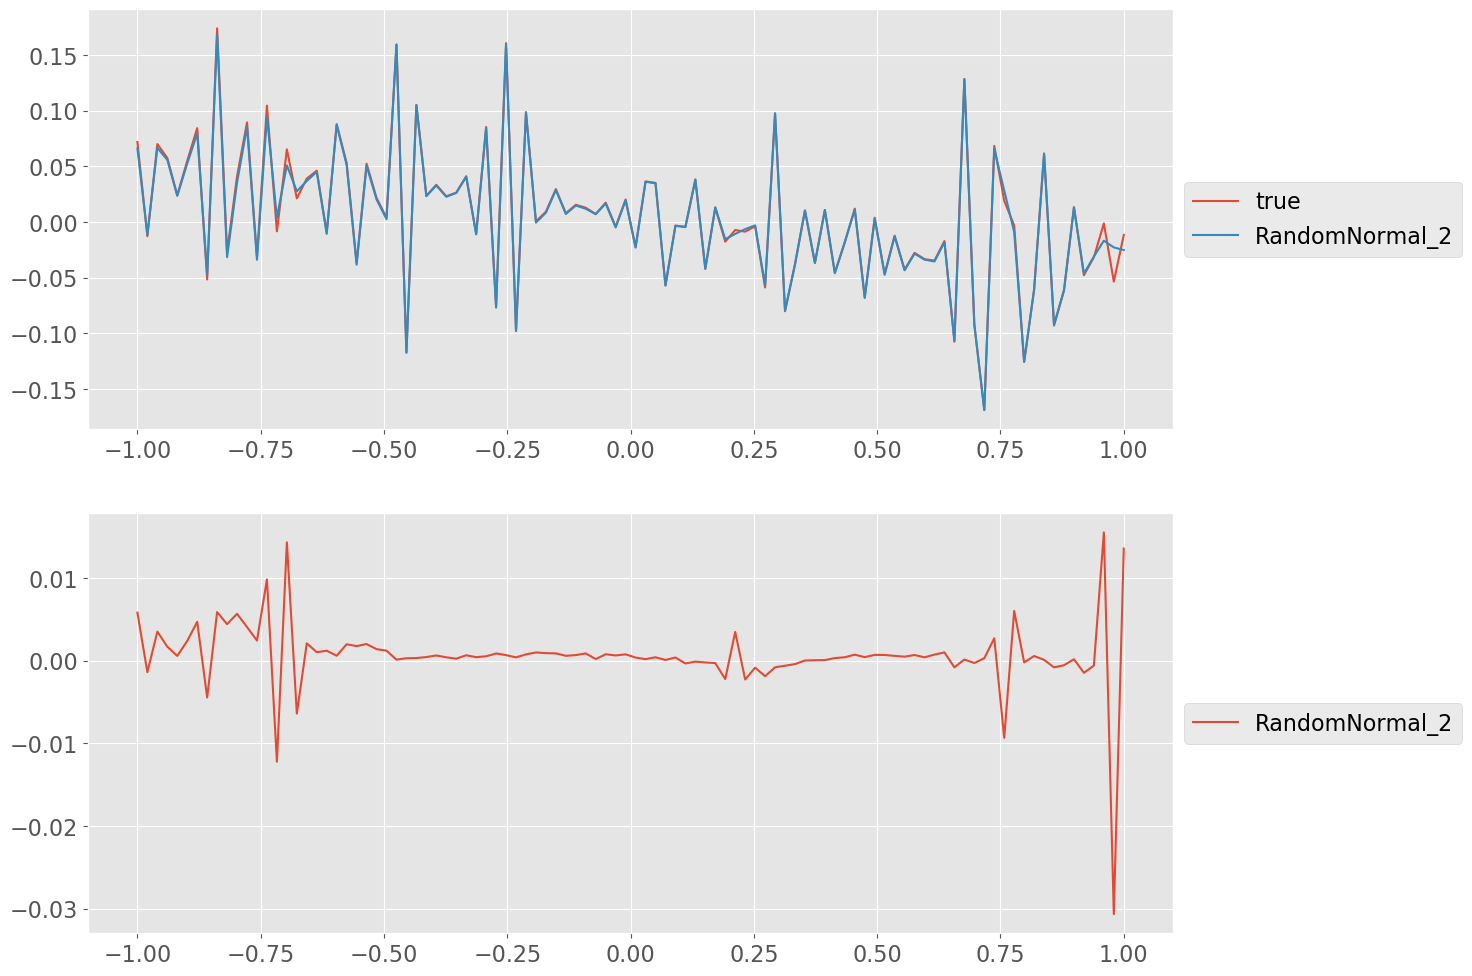

In [322]:
plt.figure(figsize=(14, 12))
plt.subplot(2, 1, 1)
plt.plot(x, yRes, label='true')
for k in historys.keys():
    plt.plot(x, models[k].predict(x), label=k)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.ylim(-0.1,0.1)

plt.subplot(2, 1, 2)
for k in historys.keys():
    plt.plot(x, yRes - models[k].predict(x), label=k)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.ylim(-0.1,0.1)

In [327]:
k = 'RandomNormal_2'
yhat_multistep = model.predict(x) + models[k].predict(x)

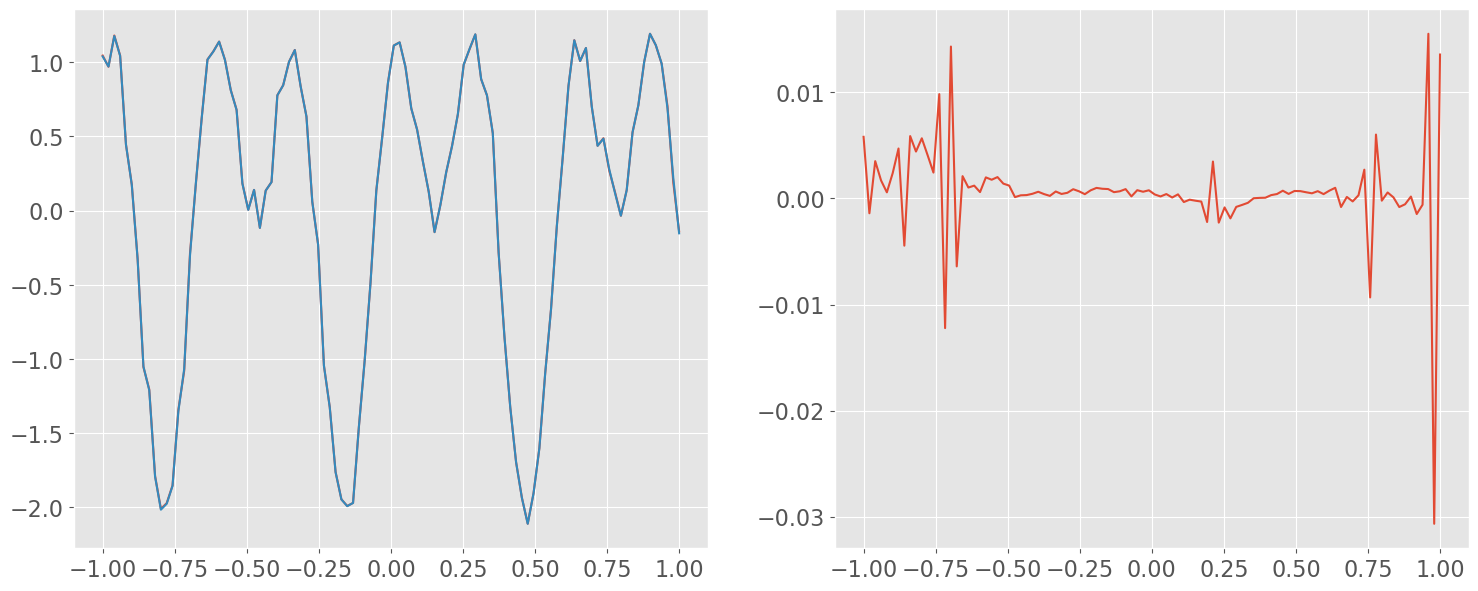

In [328]:
plot_prediction_and_error(x, y, model=None, yhat=yhat_multistep)

In [325]:
yhat_multistep_loss = tf.keras.losses.mean_squared_error(y, yhat_multistep)

(1e-12, 1)

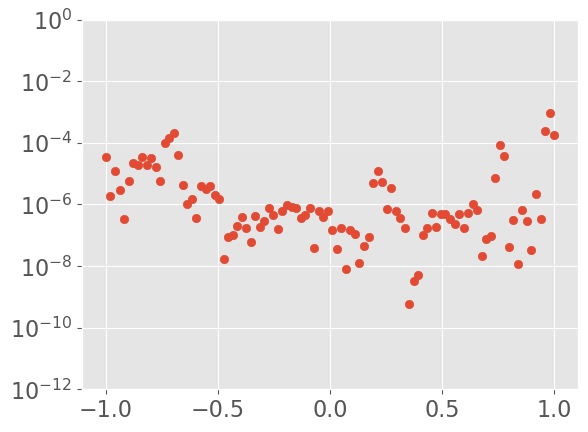

In [326]:
plt.figure()
plt.scatter(x, yhat_multistep_loss)
plt.yscale('log')
plt.ylim(1e-12, 1)